# Multivariate Time Series -Air Pollution- Vector AutoRegression (VAR) and LSTM for regression/forecasting

https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/ <br>
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ <br>
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
import statsmodels
import statsmodels.api as smt
import statsmodels.formula.api as smf           # statistics and econometrics
import statsmodels.stats.api as sms
import scipy.stats as scs
import scipy.sparse
import random
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import sklearn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #Graphics in SVG format are more sharp and legible
plt.style.use('seaborn-white') #for jupyter dark, change style
sns.set_style("darkgrid")

In [4]:
import requests

print('Beginning file download with requests')

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
r = requests.get(url)

with open('data/pollution.csv', 'wb') as series:
    series.write(r.content)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

Beginning file download with requests
200
text/plain; charset=utf-8
utf-8


In [5]:
df = pd.read_csv('data/pollution.csv', header=0)
df.head(10)

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
5   6  2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
6   7  2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
7   8  2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
8   9  2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
9  10  2010      1    1     9    NaN   -20  -8.0  1017.0   NW  27.28   0   0

In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables. <br>
<br>
Each variable that might be affected by the past values of every variable to make the predictions. Unlike AR, VAR is able to understand and use the relationship between several variables. This is useful for describing the dynamic behavior of the data and also provides better forecasting results. Additionally, implementing VAR is as simple as using any other univariate technique in python

In [6]:
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
data = pd.read_csv('data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
data.drop('No', axis=1, inplace=True)

#df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
#data = df.drop(['Date_Time'], axis=1)

# manually specify column names
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.index.name = 'date'
#data.index = df.Date_Time

# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
data = data[24:]

# summarize first 5 rows

print(data.head(5))
# save to file
data.to_csv('data/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


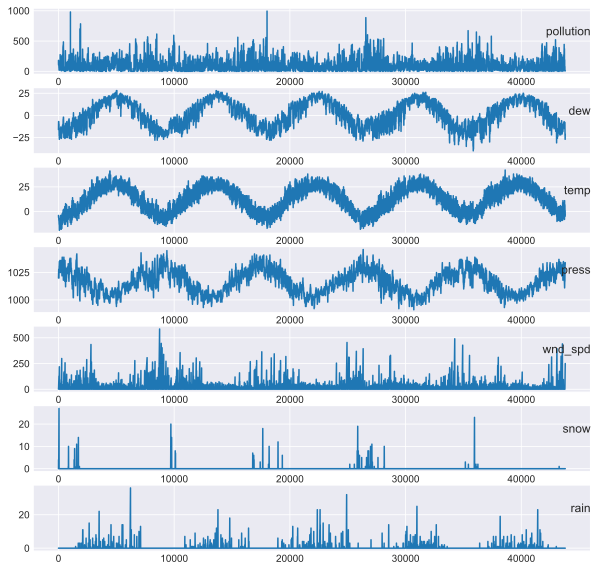

In [7]:
data = pd.read_csv('data/pollution.csv', header=0, index_col=0)
print(data.head())
values = data.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure(figsize=(10,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [8]:
data.tail()

pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97     0     0
2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78     0     0
2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70     0     0
2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72     0     0
2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85     0     0

Since the missing values in the data are replaced with a value -200, we will have to impute the missing value with a better number. Consider this – if the present dew point value is missing, we can safely assume that it will be close to the value of the previous hour. Makes sense, right? Here, I will impute -200 with the previous value.

You can choose to substitute the value using the average of a few previous values, or the value at the same time on the previous day (you can share your idea(s) of imputing missing values in the comments section below).

In [9]:
#missing value treatment
cols = data.columns
for j in cols:
    for i in range(0,len(data)):
        if data[j][i] == -200:
            data[j][i] = data[j][i-1]

#data = data.fillna(method=’ffill’)

In [10]:
data.dtypes, data.isna().sum()

(pollution    float64
 dew            int64
 temp         float64
 press        float64
 wnd_dir       object
 wnd_spd      float64
 snow           int64
 rain           int64
 dtype: object, pollution    0
 dew          0
 temp         0
 press        0
 wnd_dir      0
 wnd_spd      0
 snow         0
 rain         0
 dtype: int64)

Similar to the Augmented Dickey-Fuller test for univariate series, we have Johansen’s test for checking the stationarity of any multivariate time series data. <br>
this test only works for 12 variables so drop a random variable and test it again in the next iteration while dropping another random variable

In [12]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = data.drop(['wnd_dir'], axis=1)
coint_johansen(johan_test_temp, -1, 1).eig

array([6.33071843e-02, 4.89037954e-02, 4.43096986e-02, 3.27165093e-02,
       2.21873223e-02, 1.34650823e-03, 9.33589779e-10])

We can now go ahead and create the validation set to fit the model, and test the performance of the model:

In [13]:
data = data.drop(['wnd_dir'],axis=1)

In [14]:
#creating the train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

In [15]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR
model_fit = VAR(endog = train).fit()
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Oct, 2019
Time:                     23:26:15
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    9.62735
Nobs:                     35039.0    HQIC:                   9.61814
Log likelihood:          -516401.    FPE:                    14970.4
AIC:                      9.61383    Det(Omega_mle):         14946.5
--------------------------------------------------------------------
Results for equation pollution
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               84.356875        27.399157            3.079           0.002
L1.pollution         0.941050         0.001833          513.503           0.000
L1.dew               0.208874         0.021902            9.

In [16]:
prediction = model_fit.forecast(model_fit.y, steps=len(valid)) # make prediction on validation
prediction[:1] #'numpy.ndarray' object has no attribute 'head' so instead use array[:k]

array([[ 2.26789060e+01, -1.97030866e+01,  6.49716604e+00,
         1.01411310e+03,  1.33733083e+02, -8.58651392e-04,
        -1.59570902e-02]])

The predictions are in the form of an array, where each list represents the predictions of the row. We will transform this into a more presentable format.

In [17]:
#converting predictions to dataframe
cols = data.columns #needed becuase we dropped wind_dor

pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])
print(pred.head())

for j in range(0, 7): #7 for n = 7 variables add but there is only 6 values in one array
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

print(pred.head())

  pollution  dew temp press wnd_spd snow rain
0       NaN  NaN  NaN   NaN     NaN  NaN  NaN
1       NaN  NaN  NaN   NaN     NaN  NaN  NaN
2       NaN  NaN  NaN   NaN     NaN  NaN  NaN
3       NaN  NaN  NaN   NaN     NaN  NaN  NaN
4       NaN  NaN  NaN   NaN     NaN  NaN  NaN
  pollution      dew     temp    press  wnd_spd         snow       rain
0   22.6789 -19.7031  6.49717  1014.11  133.733 -0.000858651 -0.0159571
1   22.6469 -19.4186  6.02544  1014.23  129.908 -0.000883976 -0.0290475
2    22.871 -19.1458  5.58294  1014.36  126.194 -0.000209904 -0.0396439
3   23.3215  -18.884  5.16794   1014.5  122.591   0.00104679 -0.0480756
4    23.971 -18.6327  4.77879  1014.64    119.1   0.00278447 -0.0546325


After the testing on validation set, fit the model on the complete dataset

In [19]:
#make final predictions
model_fit =  VAR(endog = data).fit()

yhat = model_fit.forecast(model_fit.y, steps = 2)
print(yhat)

[[ 1.18539659e+01 -2.09622601e+01 -3.29801714e+00  1.03413547e+03
   2.38184279e+02  2.74231482e-02  1.27155257e-02]
 [ 1.19747627e+01 -2.09289153e+01 -3.56807851e+00  1.03426386e+03
   2.27155332e+02  5.17166604e-02  2.34392822e-02]]


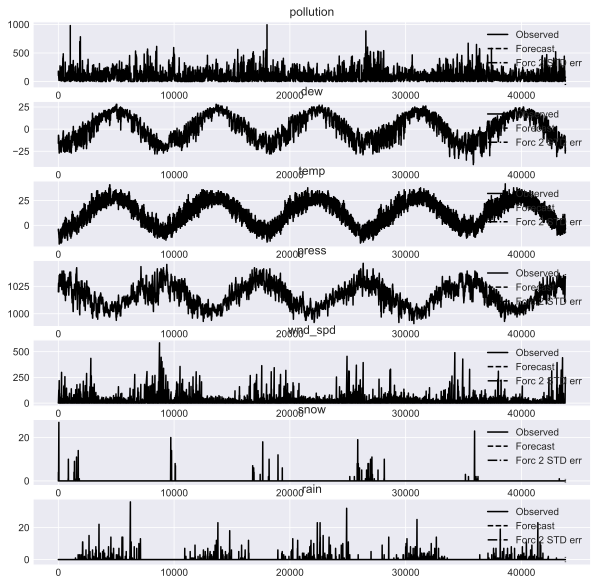

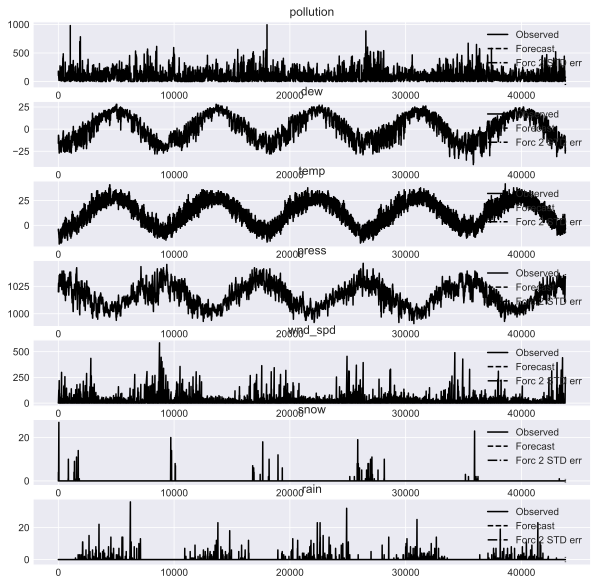

In [20]:
model_fit.plot_forecast(steps = 2)#, plot_stderr=True)

In [21]:
#converting predictions to dataframe
cols = data.columns #needed becuase we dropped wind_dor

predict = pd.DataFrame(index=range(0, len(yhat)), columns=[cols])
print(predict.head())

for j in range(0, 7): #7 for n = 7 variables add but there is only 6 values in one array
    for i in range(0, len(yhat)):
        predict.iloc[i][j] = yhat[i][j]

print(predict.head())

  pollution  dew temp press wnd_spd snow rain
0       NaN  NaN  NaN   NaN     NaN  NaN  NaN
1       NaN  NaN  NaN   NaN     NaN  NaN  NaN
  pollution      dew     temp    press  wnd_spd       snow       rain
0    11.854 -20.9623 -3.29802  1034.14  238.184  0.0274231  0.0127155
1   11.9748 -20.9289 -3.56808  1034.26  227.155  0.0517167  0.0234393


# USING LSTM

In [22]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
import statsmodels
import statsmodels.api as smt
import statsmodels.formula.api as smf           # statistics and econometrics
import statsmodels.stats.api as sms
import scipy.stats as scs
import scipy.sparse
import random
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import sklearn

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #Graphics in SVG format are more sharp and legible
plt.style.use('seaborn-white') #for jupyter dark, change style
sns.set_style("darkgrid")

Using the same datetime parsed dataset. we frame it as supervised learning program and noramalize the input. <br>
Frame the supervised learning problem as predicting the pollution at the current hour (t) given various conditions.

In [25]:
#https://github.com/SebastienMc/series_to_supervised/blob/master/series_to_supervised.py

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [26]:
# load dataset
dataset = pd.read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values

In [27]:
from sklearn import preprocessing

# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [28]:
# ensure all data is float
values = values.astype('float32')

In [29]:
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [30]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1,dropnan = True)

In [31]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [32]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

his data preparation is simple and there is more we could explore. Some ideas you could look at include:

One-hot encoding wind direction.
Making all series stationary with differencing and seasonal adjustment.
Providing more than 1 hour of input time steps.
This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

Define and Fit Model
In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [33]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [34]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [35]:
# design network
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Using TensorFlow backend.


In [36]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 5s - loss: 0.0599 - val_loss: 0.0597
Epoch 2/50
 - 2s - loss: 0.0426 - val_loss: 0.0716
Epoch 3/50
 - 2s - loss: 0.0277 - val_loss: 0.0698
Epoch 4/50
 - 2s - loss: 0.0200 - val_loss: 0.0589
Epoch 5/50
 - 2s - loss: 0.0174 - val_loss: 0.0493
Epoch 6/50
 - 2s - loss: 0.0162 - val_loss: 0.0393
Epoch 7/50
 - 2s - loss: 0.0156 - val_loss: 0.0290
Epoch 8/50
 - 2s - loss: 0.0151 - val_loss: 0.0221
Epoch 9/50
 - 1s - loss: 0.0149 - val_loss: 0.0197
Epoch 10/50
 - 2s - loss: 0.0147 - val_loss: 0.0181
Epoch 11/50
 - 2s - loss: 0.0147 - val_loss: 0.0166
Epoch 12/50
 - 2s - loss: 0.0147 - val_loss: 0.0159
Epoch 13/50
 - 2s - loss: 0.0146 - val_loss: 0.0155
Epoch 14/50
 - 2s - loss: 0.0146 - val_loss: 0.0153
Epoch 15/50
 - 2s - loss: 0.0146 - val_loss: 0.0150
Epoch 16/50
 - 2s - loss: 0.0146 - val_loss: 0.0150
Epoch 17/50
 - 2s - loss: 0.0146

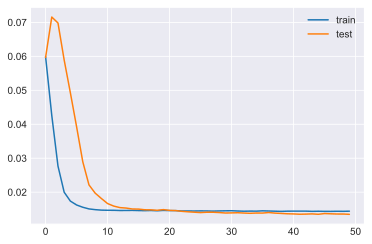

In [37]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(RMSE) that gives error in the same units as the variable itself.
After the model is fit, we can forecast for the entire test dataset.
We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error

In [38]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [39]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [40]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [41]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
import math

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.557
